In [2]:
X = np.load("C:\\Users\\HP\\Desktop\\jupyter_notebooks\\Untitled Folder\\Sequence-Models-coursera-master\\Sequence-Models-coursera-master\\Week 3\\Trigger word detection\\XY_train\\X.npy")
Y = np.load("C:\\Users\\HP\\Desktop\\jupyter_notebooks\\Untitled Folder\\Sequence-Models-coursera-master\\Sequence-Models-coursera-master\\Week 3\\Trigger word detection\\XY_train\\Y.npy")

In [1]:
import tensorflow as tf
import numpy as np
from pydub import AudioSegment
from tensorflow.keras.models import load_model
import random
import sys
import io
import os
import glob
import IPython
from td_utils import *
#from tensorflow.keras.optimizers import Adam

%matplotlib inline

c:\users\hp\anaconda3\envs\env_trigger\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
new_model=load_model("C:\\Users\\HP\\Desktop\\jupyter_notebooks\\trigger_word_model.h5")
#opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
#model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
#model.fit(X, Y, batch_size = 5, epochs=1)

In [4]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    # the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = new_model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

In [10]:
chime_file = "C:\\Users\\HP\\Desktop\\jupyter_notebooks\\Untitled Folder\\Sequence-Models-coursera-master\\Sequence-Models-coursera-master\\Week 3\\Trigger word detection\\audio_examples\\chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')

In [6]:
#///////////////////////////////////////////////////////////////////////
# Preprocess the audio to the correct format
def preprocess_audio(filename):
    # Trim or pad audio segment to 10000ms
    padding = AudioSegment.silent(duration=10000)
    segment = AudioSegment.from_wav(filename)[:10000]
    segment = padding.overlay(segment)
    # Set frame rate to 44100
    segment = segment.set_frame_rate(44100)
    # Export as wav
    segment.export(filename, format='wav')

In [7]:
your_filename = "C:\\Users\\HP\\Desktop\\jupyter_notebooks\\trigger check.wav"

In [8]:
preprocess_audio(your_filename)
IPython.display.Audio(your_filename) # listen to the audio you uploaded

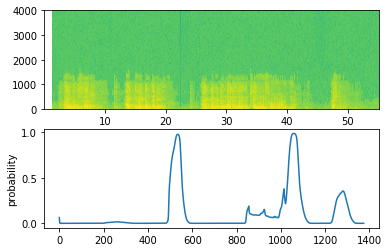

In [11]:
chime_threshold = 0.3
prediction = detect_triggerword(your_filename)
chime_on_activate(your_filename, prediction, chime_threshold)
IPython.display.Audio("./chime_output.wav")

In [9]:
#keras_file='trigger.pb'
#keras.models.save_model(new_model,'trigger.pb')

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
#converter.experimental_new_converter = True
#tflite_model = converter.convert()

# Save the TF Lite model.
#with tf.io.gfile.GFile('model.tflite', 'wb') as f:
#  f.write(tflite_model)

converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.allow_custom_ops=True
tflite_model = converter.convert()
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)
